In [1]:
import os
import gzip
import tarfile

import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import skimage
from skimage import img_as_ubyte
from skimage.exposure import histogram

import cv2

# Torch
import torch
from torch import nn
import torch.nn.functional as F

# Data Loading
from torchvision import datasets
from torch.utils import data

# Data augmentation
from torch import tensor
import torchvision.transforms as transforms

from utils_classification import *

# Load data

In [2]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

mnist_folder = os.path.join('data', 'MNIST')

train_images_path = os.path.join(mnist_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(mnist_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(mnist_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(mnist_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

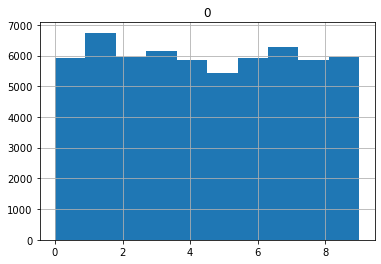

In [3]:
pd.DataFrame(train_labels).hist()
plt.show()

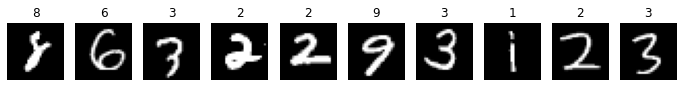

In [4]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

# Load results from task 0

In [5]:
filepath_task0 = os.path.join('data', 'classification_data', 'all_games_classification_series.pickle')
df_task0, df_numbers_only, df_not_numbers = load_segmentation_task0(filepath_task0)

## Ranks that are not numbers

In [8]:
labels_figures = {'J': 10, 'Q': 11, 'K': 12}

In [9]:
kings = df_not_numbers[df_not_numbers['rank'] == 'K'].reset_index(drop=True)
queens = df_not_numbers[df_not_numbers['rank'] == 'Q'].reset_index(drop=True)
jacks = df_not_numbers[df_not_numbers['rank'] == 'J'].reset_index(drop=True)

In [10]:
def create_figures_dataset(imgs, fig_label, labels_figures, transform, nb_samples):
    size_dataset = imgs.shape[0]
    image_shape = imgs[0].shape
    iterations = int(nb_samples/imgs.shape[0])
    
    label = labels_figures[fig_label]
    augmented_data = []
    labels = []
    for i in range(iterations):
        for img in imgs:
            augmented = img_as_ubyte(transform(img)).reshape(image_shape)
            augmented_data.append(augmented)
            labels.append(label)
    
    return np.array(augmented_data), np.array(labels)

In [11]:
train_kings = kings.image[:int(0.7*kings.shape[0])].apply(preprocess_segmented_task0)
train_queens = queens.image[:int(0.7*queens.shape[0])].apply(preprocess_segmented_task0)
train_jacks = jacks.image[:int(0.7*jacks.shape[0])].apply(preprocess_segmented_task0)

test_kings = kings.image[int(0.7*kings.shape[0]):].apply(preprocess_segmented_task0)
test_queens = queens.image[int(0.7*queens.shape[0]):].apply(preprocess_segmented_task0)
test_jacks = jacks.image[int(0.7*jacks.shape[0]):].apply(preprocess_segmented_task0)

In [12]:
transform_aug = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.RandomAffine(degrees=25, scale=(0.6, 1), shear=25),
                transforms.ToTensor(),
            ]
        )

train_kings_aug, kings_labels = create_figures_dataset(train_kings, 'K', labels_figures, transform_aug, 5000)
train_queens_aug, queens_labels = create_figures_dataset(train_queens, 'Q', labels_figures, transform_aug, 5000)
train_jacks_aug, jacks_labels = create_figures_dataset(train_jacks, 'J', labels_figures, transform_aug, 5000)

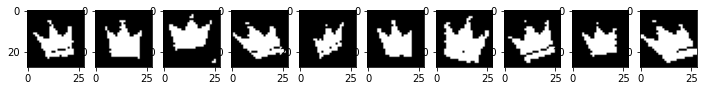

In [13]:
fig, axes = plt.subplots(1, 10, figsize=(12, 3))

for ax, img in zip(axes, train_kings_aug):
    ax.imshow(img, cmap='gray')

In [14]:
train_augmented_figs = np.concatenate((train_kings_aug, train_queens_aug, train_jacks_aug))
train_augmented_figs_labels = np.concatenate((kings_labels, queens_labels, jacks_labels))

In [15]:
val_kings = np.array([v for v in kings.image[int(0.7*kings.shape[0]):int(0.8*kings.shape[0])].apply(preprocess_segmented_task0)])
val_queens = np.array([v for v in queens.image[int(0.7*queens.shape[0]):int(0.8*queens.shape[0])].apply(preprocess_segmented_task0)])
val_jacks = np.array([v for v in jacks.image[int(0.7*jacks.shape[0]):int(0.8*jacks.shape[0])].apply(preprocess_segmented_task0)])

val_kings, val_kings_labels = create_figures_dataset(val_kings, 'K', labels_figures, transform_aug, 500)
val_queens, val_queens_labels = create_figures_dataset(val_queens, 'Q', labels_figures, transform_aug, 500)
val_jacks, val_jacks_labels = create_figures_dataset(val_jacks, 'J', labels_figures, transform_aug, 500)

val_augmented_figs = np.concatenate((val_kings, val_queens, val_jacks))
val_augmented_figs_labels = np.concatenate((val_kings_labels, val_queens_labels, val_jacks_labels))

# Load task 0 results Take 2

In [5]:
filepath_task0 = os.path.join('data', 'classification_data', 'all_games_classification_series_mnist.pickle')
df_task0, df_numbers_only, df_not_numbers = load_segmentation_task0(filepath_task0)

Text(0.5, 1.0, 'K')

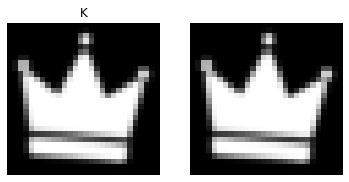

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(df_not_numbers.image[11], cmap='gray')
ax[1].imshow(img_as_ubyte(df_not_numbers.image[11]), cmap='gray')

ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title(df_not_numbers['rank'][11])


## Ranks that are not numbers

In [20]:
labels_figures = {'J': 10, 'Q': 11, 'K': 12}

In [27]:
kings = df_not_numbers[df_not_numbers['rank'] == 'K'].reset_index(drop=True)
queens = df_not_numbers[df_not_numbers['rank'] == 'Q'].reset_index(drop=True)
jacks = df_not_numbers[df_not_numbers['rank'] == 'J'].reset_index(drop=True)

In [28]:
def create_figures_dataset(imgs, fig_label, labels_figures, transform, nb_samples):
    size_dataset = imgs.shape[0]
    image_shape = imgs[0].shape
    iterations = int(nb_samples/imgs.shape[0])
    
    label = labels_figures[fig_label]
    augmented_data = []
    labels = []
    for i in range(iterations):
        for img in imgs:
            augmented = img_as_ubyte(transform(img)).reshape(image_shape)
            augmented_data.append(augmented)
            labels.append(label)
    
    return np.array(augmented_data), np.array(labels)

In [ ]:
def get_train_val_test_figures(df_not_numbers, labels_figures, transform):
    kings = df_not_numbers[df_not_numbers['rank'] == 'K'].reset_index(drop=True)
    queens = df_not_numbers[df_not_numbers['rank'] == 'Q'].reset_index(drop=True)
    jacks = df_not_numbers[df_not_numbers['rank'] == 'J'].reset_index(drop=True)
    
    # Train
    train_kings = kings.image[:int(0.7*kings.shape[0])].apply(img_as_ubyte)
    train_queens = queens.image[:int(0.7*queens.shape[0])].apply(img_as_ubyte)
    train_jacks = jacks.image[:int(0.7*jacks.shape[0])].apply(img_as_ubyte)
    
    train_kings_aug, kings_labels = create_figures_dataset(train_kings, 'K', labels_figures, transform, 5000)
    train_queens_aug, queens_labels = create_figures_dataset(train_queens, 'Q', labels_figures, transform, 5000)
    train_jacks_aug, jacks_labels = create_figures_dataset(train_jacks, 'J', labels_figures, transform, 5000)
    
    train_augmented_figs = np.concatenate((train_kings_aug, train_queens_aug, train_jacks_aug))
    train_augmented_figs_labels = np.concatenate((kings_labels, queens_labels, jacks_labels))
    
    # Validation 
    val_kings, val_kings_labels = create_figures_dataset(val_kings, 'K', labels_figures, transform_aug, 500)
    val_queens, val_queens_labels = create_figures_dataset(val_queens, 'Q', labels_figures, transform_aug, 500)
    val_jacks, val_jacks_labels = create_figures_dataset(val_jacks, 'J', labels_figures, transform_aug, 500)

    val_augmented_figs = np.concatenate((val_kings, val_queens, val_jacks))
    val_augmented_figs_labels = np.concatenate((val_kings_labels, val_queens_labels, val_jacks_labels))
    
    
    # Test
    test_kings = np.array([v for v in kings.image[int(0.8*kings.shape[0]):].apply(img_as_ubyte)])
    test_queens = np.array([v for v in queens.image[int(0.8*queens.shape[0]):].apply(img_as_ubyte)])
    test_jacks = np.array([v for v in jacks.image[int(0.8*jacks.shape[0]):].apply(img_as_ubyte)])
    
    test_figs = np.concatenate((test_kings, test_queens, test_jacks))
    test_figs_labels = np.array([12]*test_kings.shape[0] + [11]*test_queens.shape[0] + [10]*test_jacks.shape[0])
    
    return train_augmented_figs, train_augmented_figs_labels, val_augmented_figs, val_augmented_figs_labels, \
                test_figs, test_figs_labels

In [31]:
train_kings = kings.image[:int(0.7*kings.shape[0])].apply(img_as_ubyte)
train_queens = queens.image[:int(0.7*queens.shape[0])].apply(img_as_ubyte)
train_jacks = jacks.image[:int(0.7*jacks.shape[0])].apply(img_as_ubyte)

test_kings = kings.image[int(0.7*kings.shape[0]):].apply(img_as_ubyte)
test_queens = queens.image[int(0.7*queens.shape[0]):].apply(img_as_ubyte)
test_jacks = jacks.image[int(0.7*jacks.shape[0]):].apply(img_as_ubyte)

In [32]:
transform_aug = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.RandomAffine(degrees=25, scale=(0.7, 1), shear=25),
                transforms.ToTensor(),
            ]
        )

train_kings_aug, kings_labels = create_figures_dataset(train_kings, 'K', labels_figures, transform_aug, 5000)
train_queens_aug, queens_labels = create_figures_dataset(train_queens, 'Q', labels_figures, transform_aug, 5000)
train_jacks_aug, jacks_labels = create_figures_dataset(train_jacks, 'J', labels_figures, transform_aug, 5000)

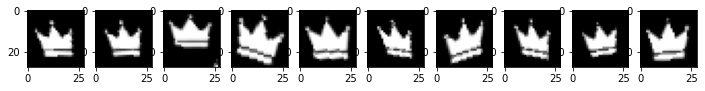

In [33]:
fig, axes = plt.subplots(1, 10, figsize=(12, 3))

for ax, img in zip(axes, train_kings_aug):
    ax.imshow(img, cmap='gray')

In [34]:
train_augmented_figs = np.concatenate((train_kings_aug, train_queens_aug, train_jacks_aug))
train_augmented_figs_labels = np.concatenate((kings_labels, queens_labels, jacks_labels))

In [94]:
kings.image[int(0.7*kings.shape[0]):int(0.8*kings.shape[0])]

0    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: image, dtype: object

In [35]:
val_kings = np.array([v for v in kings.image[int(0.7*kings.shape[0]):int(0.8*kings.shape[0])].apply(img_as_ubyte)])
val_queens = np.array([v for v in queens.image[int(0.7*queens.shape[0]):int(0.8*queens.shape[0])].apply(img_as_ubyte)])
val_jacks = np.array([v for v in jacks.image[int(0.7*jacks.shape[0]):int(0.8*jacks.shape[0])].apply(img_as_ubyte)])

val_kings, val_kings_labels = create_figures_dataset(val_kings, 'K', labels_figures, transform_aug, 500)
val_queens, val_queens_labels = create_figures_dataset(val_queens, 'Q', labels_figures, transform_aug, 500)
val_jacks, val_jacks_labels = create_figures_dataset(val_jacks, 'J', labels_figures, transform_aug, 500)

val_augmented_figs = np.concatenate((val_kings, val_queens, val_jacks))
val_augmented_figs_labels = np.concatenate((val_kings_labels, val_queens_labels, val_jacks_labels))

# Data loader and augmentation

In [36]:
transform_aug = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.RandomAffine(degrees=25, scale=(0.8, 1.1), shear=20),
                transforms.ToTensor(),
            ]
        )

augmented_train = augment_data(train_images, transform_aug)

In [37]:
# Parameters of our DataLoader
params = {'batch_size': 128,
          'shuffle': True}

# Creation of a train/test dataset & dataloader
train_merged_images = np.concatenate((train_images, augmented_train, train_augmented_figs))
train_merged_labels = np.concatenate((train_labels, train_labels, train_augmented_figs_labels))

test_merged_images = np.concatenate((test_images, val_augmented_figs))
test_merged_labels = np.concatenate((test_labels, val_augmented_figs_labels)) 

ds_train = MNISTDataset(train_merged_images, train_merged_labels, transform=transforms.ToTensor())
dl_train = data.DataLoader(ds_train, **params)

ds_test = MNISTDataset(test_merged_images, test_merged_labels, transform=transforms.ToTensor())
dl_test = data.DataLoader(ds_test, **params)

In [41]:
task0_numbers = np.array([v for v in df_numbers_only.image.apply(img_as_ubyte)])

ds_test_task0 = MNISTDataset(task0_numbers, df_numbers_only['rank'].to_numpy().astype(np.int64), 
                             transform=transforms.ToTensor())
dl_test_task0 = data.DataLoader(ds_test_task0, **params)

In [42]:
test_kings = np.array([v for v in kings.image[int(0.8*kings.shape[0]):].apply(img_as_ubyte)])
test_queens = np.array([v for v in queens.image[int(0.8*queens.shape[0]):].apply(img_as_ubyte)])
test_jacks = np.array([v for v in jacks.image[int(0.8*jacks.shape[0]):].apply(img_as_ubyte)])

task0_figures_labels = np.array([12]*test_kings.shape[0] + [11]*test_queens.shape[0] + [10]*test_jacks.shape[0])
task0_figures = np.concatenate((test_kings, test_queens, test_jacks))

ds_test_task0_figs = MNISTDataset(task0_figures, 
                                  task0_figures_labels.astype(np.int64), 
                                  transform=transforms.ToTensor())
dl_test_task0_figs = data.DataLoader(ds_test_task0_figs, **params)

In [45]:
task0_figures_labels

array([12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10,
       10])

# Model

### CNN 1

In [20]:
# defining the model architecture
class Net1(nn.Module):   
    def __init__(self, nb_classes=13):
        super(Net1, self).__init__()

        self.cnn_layers = nn.Sequential(
          # Defining first 2D convolution layer
          nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          # Defining second 2D convolution layer
          nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
          nn.Linear(4 * 7 * 7, nb_classes)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [22]:
model1 = Net1()

### CNN 2

In [46]:
class Net2(nn.Module):
    def __init__(self, nb_classes=13):
        super(Net2, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, nb_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [47]:
model2 = Net2()

### CNN 3

In [54]:
# Create CNN Model
class Net3(nn.Module):
    def __init__(self, nb_classes=13):
        super(Net3, self).__init__()
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 5 * 5, nb_classes) 
    
    def forward(self, x):
        # Set 1
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        
        # Set 2
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        
        #Flatten
        out = out.view(out.size(0), -1)

        #Dense
        out = self.fc1(out)
        
        return out

In [55]:
model3 = Net3()

## Training

In [49]:
def train_loop(dataloader, model, loss_func, optimizer):
    for it, (X, y) in enumerate(dataloader):
        
        # Compute prediction and loss
        pred = model(X)            # Forward pass
        loss = loss_func(pred, y)  # Compute the loss

        # Backpropagation
        optimizer.zero_grad()      # Reinitialise the accumulated gradients
        loss.backward()            # Recompute the new gradients
        optimizer.step()           # Update the parameters of the model
        
        # Compute the accuracy on this batch of images
        accuracy_tr = (pred.argmax(1) == y).type(torch.float).sum().item() / len(X)
        
        #if (it+1 == len(dataloader)):
        print('It {}/{}:\tLoss train: {:.5f}, Accuracy train: {:.2%}'.
              format(it + 1, len(dataloader), loss, accuracy_tr), end='\r')
    print()
    
def test_loop(dataloader, model, loss_func, print_pred=False):
    size = len(dataloader.dataset)
    test_loss, accuracy = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_func(pred, y).item()
            
            if print_pred:
                print(list(zip(pred.argmax(1).tolist(), y.tolist())))
            
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Statistics over all the batchs
    test_loss /= size
    accuracy /= size    
    
    print(f"Test Error:\n\tAvg loss: {test_loss:.5f}, Accuracy: {accuracy:.2%}\n")

### Model 2

In [50]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
learning_rate = 1e-3
opt = torch.optim.Adam(model2.parameters(), lr=learning_rate)
epochs = 7

# Train & test our model until convergence (here 15 epochs is sufficient as we don't have too many parameters)
for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    train_loop(dl_train, model2, criterion, opt)
    test_loop(dl_test, model2, criterion)

Epoch 1
-------------------------------
It 1055/1055:	Loss train: 0.06984, Accuracy train: 97.56%%
Test Error:
	Avg loss: 0.01013, Accuracy: 85.98%

Epoch 2
-------------------------------
It 1055/1055:	Loss train: 0.02080, Accuracy train: 100.00%
Test Error:
	Avg loss: 0.00906, Accuracy: 86.26%

Epoch 3
-------------------------------
It 1055/1055:	Loss train: 0.01704, Accuracy train: 98.78%%
Test Error:
	Avg loss: 0.00863, Accuracy: 86.30%

Epoch 4
-------------------------------
It 1055/1055:	Loss train: 0.10544, Accuracy train: 98.78%%
Test Error:
	Avg loss: 0.00765, Accuracy: 86.33%

Epoch 5
-------------------------------
It 1055/1055:	Loss train: 0.00402, Accuracy train: 100.00%
Test Error:
	Avg loss: 0.00821, Accuracy: 86.42%

Epoch 6
-------------------------------
It 1055/1055:	Loss train: 0.00051, Accuracy train: 100.00%
Test Error:
	Avg loss: 0.00843, Accuracy: 86.32%

Epoch 7
-------------------------------
It 1055/1055:	Loss train: 0.00519, Accuracy train: 100.00%
Test Er

In [51]:
test_loop(dl_test_task0, model2, criterion)

Test Error:
	Avg loss: 0.01169, Accuracy: 82.08%



In [52]:
test_loop(dl_test_task0_figs, model2, criterion, print_pred=True)

[(10, 10), (11, 11), (12, 12), (12, 12), (10, 10), (12, 12), (11, 11), (11, 11), (12, 12), (10, 10), (12, 12), (11, 11), (11, 11), (1, 10), (10, 10), (10, 10), (12, 12), (11, 11)]
Test Error:
	Avg loss: 0.02111, Accuracy: 94.44%



In [89]:
preds = model2(torch.Tensor(np.expand_dims(task0_numbers, 1)))
preds.argmax(1)

tensor([ 8,  0,  5, 10, 10,  3,  7,  3,  7,  7,  4,  0,  6,  3,  2,  8,  7,  3,
         4,  7,  7,  6,  9,  7, 10,  5,  5,  4,  7,  6,  1,  4,  2,  5,  8,  2,
         7,  5,  0,  2,  2,  7, 10,  5,  8,  4,  8,  2,  5,  1,  5,  0,  0,  3,
         4,  1,  0,  7,  7,  2,  7,  1,  6,  4,  8,  2,  1,  7,  0,  3,  9,  5,
         6,  5,  3,  6,  6,  3,  7,  5,  2,  1,  1,  7,  6,  3,  1,  3,  7,  4,
         2,  6,  9,  7,  0,  8,  5,  0,  0,  5,  1,  3,  4,  0,  1,  2,  6,  7,
         4,  5,  5,  6,  5,  4,  2,  8,  7,  8,  8,  3,  7,  5,  3,  9,  3,  5,
         7,  7,  3,  7,  8,  8,  4,  2,  4,  0, 10,  0,  8, 11,  7,  0,  1,  2,
         0,  5,  2,  5,  7, 11,  2,  8,  4,  6,  3,  5,  6,  6,  7,  7,  2,  9,
         0,  2,  3,  7,  6,  8,  4,  4,  6,  3,  5,  5,  3,  6,  6,  3,  8,  5,
         7,  5,  2,  8,  4,  3,  4,  2,  6,  0, 10,  7,  7,  0,  4, 10,  5,  0,
         1,  7,  5,  4,  0,  7,  6,  8,  8,  5,  5,  3,  7,  1,  2,  9, 10,  5,
         7,  7,  3,  1,  0,  2,  3,  1, 

In [82]:
for X, y in dl_test_task0_figs:
    print(X.shape)

torch.Size([18, 1, 28, 28])


# Save best model

In [53]:
models_dir = os.path.join('data', 'models')

if not os.path.isdir(models_dir):
    os.mkdir(models_dir)

torch.save(model2.state_dict(), os.path.join(models_dir, "model2.pt"))

# Predict rank

In [90]:
def predict_rank(imgs, model_class, model_path):
    model = model_class()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    input_model = torch.Tensor(np.expand_dims(imgs, 1))
    preds = model(input_model).argmax(1)
    
    return preds

In [91]:
predict_rank(task0_numbers, Net2, "data/models/model2.pt")

tensor([ 8,  0,  5, 10, 10,  3,  7,  3,  7,  7,  4,  0,  6,  3,  2,  8,  7,  3,
         4,  7,  7,  6,  9,  7, 10,  5,  5,  4,  7,  6,  1,  4,  2,  5,  8,  2,
         7,  5,  0,  2,  2,  7, 10,  5,  8,  4,  8,  2,  5,  1,  5,  0,  0,  3,
         4,  1,  0,  7,  7,  2,  7,  1,  6,  4,  8,  2,  1,  7,  0,  3,  9,  5,
         6,  5,  3,  6,  6,  3,  7,  5,  2,  1,  1,  7,  6,  3,  1,  3,  7,  4,
         2,  6,  9,  7,  0,  8,  5,  0,  0,  5,  1,  3,  4,  0,  1,  2,  6,  7,
         4,  5,  5,  6,  5,  4,  2,  8,  7,  8,  8,  3,  7,  5,  3,  9,  3,  5,
         7,  7,  3,  7,  8,  8,  4,  2,  4,  0, 10,  0,  8, 11,  7,  0,  1,  2,
         0,  5,  2,  5,  7, 11,  2,  8,  4,  6,  3,  5,  6,  6,  7,  7,  2,  9,
         0,  2,  3,  7,  6,  8,  4,  4,  6,  3,  5,  5,  3,  6,  6,  3,  8,  5,
         7,  5,  2,  8,  4,  3,  4,  2,  6,  0, 10,  7,  7,  0,  4, 10,  5,  0,
         1,  7,  5,  4,  0,  7,  6,  8,  8,  5,  5,  3,  7,  1,  2,  9, 10,  5,
         7,  7,  3,  1,  0,  2,  3,  1, 